In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import matplotlib
from pylab import *
obs_col = '#32CD32'
face_col = 'black'
obj_col = 'white'
line_col = '#595756'
import scipy.stats as stats
norm = stats.norm

### Data import and minor prep

In [2]:
# import the csv of last years forecasts
forecasts = pd.read_csv("../data/da_noda_all_ensembles.csv")

# format dates
forecasts['time'] = pd.to_datetime(forecasts['time'])
forecasts['issue_time'] = pd.to_datetime(forecasts['issue_time'])

forecasts.head()

,Unnamed: 0,issue_time,time,seg_id_nat,ensemble,max_temp,model_name,lead_time,obs_max_temp_c
0,1,2021-04-16,2021-04-16,1450,1,7.409235,DA,0,8.4
1,2,2021-04-16,2021-04-17,1450,1,6.990790,DA,1,7.6
2,3,2021-04-16,2021-04-18,1450,1,7.445290,DA,2,9.0
3,4,2021-04-16,2021-04-19,1450,1,9.569366,DA,3,10.2
4,5,2021-04-16,2021-04-20,1450,1,11.465050,DA,4,10.9


In [3]:
# Separate the forecasts that always used DA
forecasts_DA = forecasts[forecasts['model_name'] == 'DA']
# And those that never used DA
forecasts_no_DA = forecasts[forecasts['model_name'] == 'no_DA']

In [4]:
# Pick a random day and stream segment for the composite figure
rand_i = np.random.choice(forecasts.shape[0])
rand_day = forecasts['time'][rand_i]
rand_seg = forecasts['seg_id_nat'][rand_i]
print('Date = \t\t\t', rand_day, '\nStream segment = \t', rand_seg)

Date = 			 2021-06-02 00:00:00 
Stream segment = 	 1641


### Use some specific, knowns days to make a story

In [5]:
# Look at the forecast made 1 day ago, relative to...
days_ago = -1
# ...the day that was 7 days ahead of our random day 
    # seed is set so this is always the same
# i.e., the forecast made 6 days in the future for the 7th day in the future
curr_day = rand_day + pd.Timedelta(7, unit = 'days')
prev_day = curr_day + pd.Timedelta(days_ago, unit = 'days')

# Partition the data
prev_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == prev_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
prev_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == prev_day) &
                              (forecasts_no_DA['time'] == curr_day) &
                              (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(prev_day_DA['max_temp'])
no_DA_params = norm.fit(prev_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(prev_day_DA['max_temp'].min(), prev_day_no_DA['max_temp'].min())
xmax = max(prev_day_DA['max_temp'].max(), prev_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

Last year, we provided forecasts of stream temperature to reservoir managers in the Delaware River Basin. These forecasts utilized weather ensembles and Monte Carlo dropout to provide probabilistic forecasts - that is, we predict the distribution of possible stream temperatures, not just one estimate of stream temperature. One example of that can be seen here:

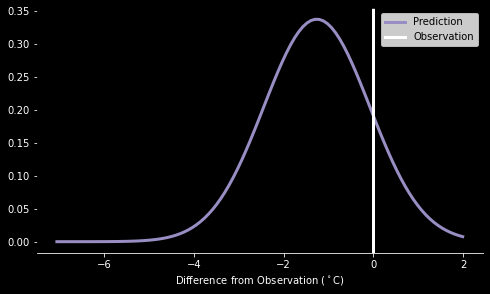

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (16*0.5, 9*0.5), facecolor = face_col)

# Plot the no DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', label = 'Prediction', linewidth = 3)
# Plot the distribution 
plt.axvline(0, color = obj_col, label = 'Observation', linewidth = 3)

# Aesthetics
ax.set_facecolor(face_col)
ax.tick_params(axis='x', color=obj_col, labelcolor = obj_col)
ax.tick_params(axis='y', color=obj_col, labelcolor = obj_col)
ax.spines['bottom'].set_color(obj_col)
ax.set_xlabel('Difference from Observation (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.legend(fontsize = 10);

plt.savefig('../non_gif_images/PlainForecast.png', bbox_inches = 'tight', facecolor = face_col, dpi = 300)

You can see that the real temperature that occured at this time falls into our predicted distribution. One method we used to improve these forecasts was DA which uses recently observed temperatures to correct/adjust our model's forecast. When we use DA along the previously observed days, this is what our forecast is adjusted to 1 day prior to the observation:

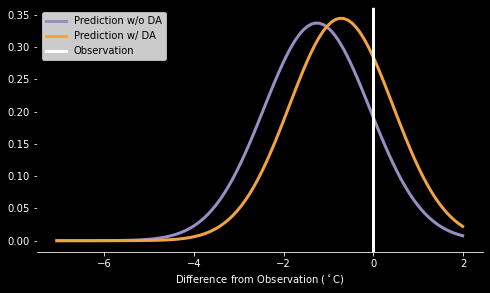

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (16*0.5, 9*0.5), facecolor = face_col)

# No DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, linewidth = 3, color = '#998ec3', label = 'Prediction w/o DA')
# DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf, linewidth = 3, color = '#f1a340', label = 'Prediction w/ DA')
# Observation
plt.axvline(0, color = obj_col, linewidth = 3, label = 'Observation')

# Aesthetics
ax.set_facecolor(face_col)
ax.tick_params(axis='x', color=obj_col, labelcolor = obj_col)
ax.tick_params(axis='y', color=obj_col, labelcolor = obj_col)
ax.spines['bottom'].set_color(obj_col)
ax.set_xlabel('Difference from Observation (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.legend(fontsize = 10)

plt.savefig('../non_gif_images/BothForecasts.png', bbox_inches = 'tight', facecolor = face_col, dpi = 300)

As you can see, this adjusted distribution is pretty similar to the previous one because the original forecast did a pretty good job, but now we have assigned a higher probability to the values closer to where the observation ended up occurring at. One way to visualize what was adjusted is to display the difference between these distributions. Like this:

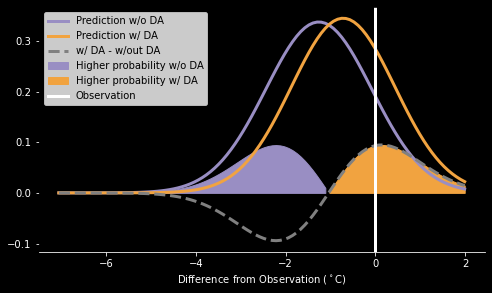

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (16*0.5, 9*0.5), facecolor = face_col)

# No DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', linewidth = 3, label = 'Prediction w/o DA')
# DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', linewidth = 3, label = 'Prediction w/ DA')
# Difference between the curves
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf - no_DA_pdf, linewidth = 3, label = 'w/ DA - w/out DA', color = 'gray', linestyle = '--')
# Shade where no DA exceeds DA
plt.fill_between(x[DA_pdf <= no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
# Shade where DA exceeds no DA
plt.fill_between(x[DA_pdf > no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
# Observation
plt.axvline(0, color = obj_col, linewidth = 3, label = 'Observation')

# Aesthetics
ax.set_facecolor(face_col)
ax.tick_params(axis='x', color=obj_col, labelcolor = obj_col)
ax.tick_params(axis='y', color=obj_col, labelcolor = obj_col)
ax.spines['bottom'].set_color(obj_col)
ax.set_xlabel('Difference from Observation (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.legend(fontsize = 10)

plt.savefig('../non_gif_images/DA_GoodShift.png', bbox_inches = 'tight', facecolor = face_col, dpi = 300)

Here, the purple shade represents the location and placement of probability that was adjusted away while the orange is what replaced it. As we would like, values further from the observation were adjusted away in favor of those closer to it.

Sometimes, assimilating recent observations shifts the distribution to a better location. Other times, the location of the distribution stays largely the same, but we increase confidence at towards the center.

In [9]:
# Look at the forecast made 1 day ago, relative to...
days_ago = -1
# ...our random day 
    # seed is set so this is always the same
# i.e., the forecast made 1 day ago for today(=random day)
curr_day = rand_day + pd.Timedelta(0, unit = 'days')
prev_day = curr_day + pd.Timedelta(days_ago, unit = 'days')

# Partition the data
prev_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == prev_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
prev_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == prev_day) &
                              (forecasts_no_DA['time'] == curr_day) &
                              (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(prev_day_DA['max_temp'])
no_DA_params = norm.fit(prev_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(prev_day_DA['max_temp'].min(), prev_day_no_DA['max_temp'].min())
xmax = max(prev_day_DA['max_temp'].max(), prev_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

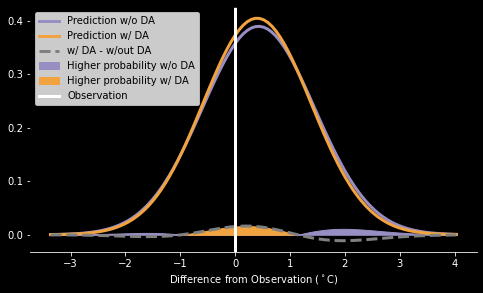

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (16*0.5, 9*0.5), facecolor = face_col)

# No DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', linewidth = 3, label = 'Prediction w/o DA')
# DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', linewidth = 3, label = 'Prediction w/ DA')
# Difference between the curves
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf - no_DA_pdf, linewidth = 3, label = 'w/ DA - w/out DA', color = 'gray', linestyle = '--')
# Shade where no DA exceeds DA
plt.fill_between(x[DA_pdf <= no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
# Shade where DA exceeds no DA
plt.fill_between(x[DA_pdf > no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
# Observation
plt.axvline(0, color = obj_col, linewidth = 3, label = 'Observation')

# Aesthetics
ax.set_facecolor(face_col)
ax.tick_params(axis='x', color=obj_col, labelcolor = obj_col)
ax.tick_params(axis='y', color=obj_col, labelcolor = obj_col)
ax.spines['bottom'].set_color(obj_col)
ax.set_xlabel('Difference from Observation (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.legend(fontsize = 10)

plt.savefig('../non_gif_images/DA_ConfidBoost.png', bbox_inches = 'tight', facecolor = face_col, dpi = 300)

And sometimes the adjustments that DA makes lead to a worse forecast (but thankfully this is not generally the case)

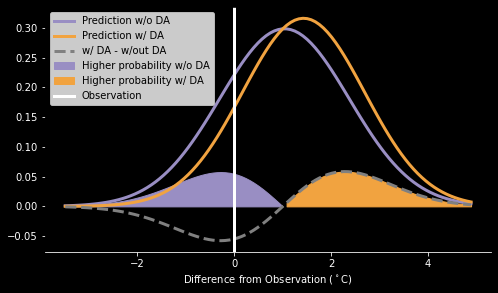

In [11]:
# Look at the forecast made 1 day ago, relative to...
days_ago = -1
# ...our random day 
    # seed is set so this is always the same
# i.e., the forecast made 1 day ago for today(=random day)
curr_day = rand_day + pd.Timedelta(11, unit = 'days')
prev_day = curr_day + pd.Timedelta(days_ago, unit = 'days')

# Partition the data
prev_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == prev_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
prev_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == prev_day) &
                              (forecasts_no_DA['time'] == curr_day) &
                              (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(prev_day_DA['max_temp'])
no_DA_params = norm.fit(prev_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(prev_day_DA['max_temp'].min(), prev_day_no_DA['max_temp'].min())
xmax = max(prev_day_DA['max_temp'].max(), prev_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

# Plot set up
fig, ax = plt.subplots(1, 1, figsize = (16*0.5, 9*0.5), facecolor = face_col)

# No DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', linewidth = 3, label = 'Prediction w/o DA')
# DA curve
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', linewidth = 3, label = 'Prediction w/ DA')
# Difference between the curves
plt.plot(x - prev_day_DA['obs_max_temp_c'].unique(), DA_pdf - no_DA_pdf, linewidth = 3, label = 'w/ DA - w/out DA', color = 'gray', linestyle = '--')
# Shade where no DA exceeds DA
plt.fill_between(x[DA_pdf <= no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
# Shade where DA exceeds no DA
plt.fill_between(x[DA_pdf > no_DA_pdf] - prev_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
# Observation
plt.axvline(0, color = obj_col, linewidth = 3, label = 'Observation')

# Aesthetics
ax.set_facecolor(face_col)
ax.tick_params(axis='x', color=obj_col, labelcolor = obj_col)
ax.tick_params(axis='y', color=obj_col, labelcolor = obj_col)
ax.spines['bottom'].set_color(obj_col)
ax.set_xlabel('Difference from Observation (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.legend(fontsize = 10)

plt.savefig('../non_gif_images/DA_BadShift.png', bbox_inches = 'tight', facecolor = face_col, dpi = 300)

In [12]:
# Get a 1-week out list consisting of days we're interested in
# reference = our randomly selected day early
day_ls = []
for i in range(7):
    day_ls.append(rand_day + pd.Timedelta(i, unit = 'days'))
day_ls

[Timestamp('2021-06-02 00:00:00'),
 Timestamp('2021-06-03 00:00:00'),
 Timestamp('2021-06-04 00:00:00'),
 Timestamp('2021-06-05 00:00:00'),
 Timestamp('2021-06-06 00:00:00'),
 Timestamp('2021-06-07 00:00:00'),
 Timestamp('2021-06-08 00:00:00')]

In [13]:
# For plot formatting purposes, extract the minimum and maximum prediction
# across the days of interest
min_ls = []
max_ls = []
for i in range(-7, 7):
    curr_day = rand_day + pd.Timedelta(i, unit = 'days')
    curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == curr_day) &
                               (forecasts_DA['time'] >= min(day_ls)) &
                               (forecasts_DA['time'] <= max(day_ls)) &
                               (forecasts_DA['seg_id_nat'] == rand_seg)]
    curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == curr_day) &
                                     (forecasts_no_DA['time'] >= min(day_ls)) &
                                     (forecasts_no_DA['time'] <= max(day_ls)) &
                                     (forecasts_no_DA['seg_id_nat'] == rand_seg)]
    min_ls.append((curr_day_DA['max_temp'] - curr_day_DA['obs_max_temp_c']).min())
    max_ls.append((curr_day_DA['max_temp'] - curr_day_DA['obs_max_temp_c']).max())

In [14]:
# Build a manual color bar for the DA and No DA aesthetics
cmap_ls1 = []
cmap_ls2 = []
for i in [7, 6, 5, 4, 3, 2, 1]:
    cmap_ls1.append(matplotlib.colors.to_rgba('#f1a340', alpha = 1/(i + 0.33)))
    cmap_ls2.append(matplotlib.colors.to_rgba('#998ec3', alpha = 1/(i + 0.33)))

This is what these DA differences look like if we view them for a random week with our 7-day ahead forecasts

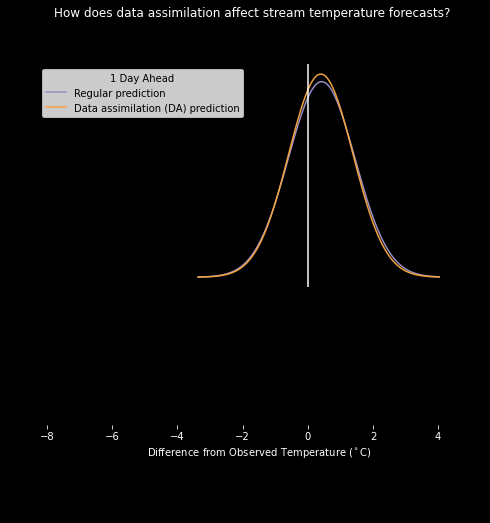

In [15]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [8,
                                                                                                    0, 0, 0, 0, 
                                                                                                    0, 0, 0,0.1,0.1]})
fig.suptitle('How does data assimilation affect stream temperature forecasts?\n',
                         color = obj_col, fontsize = 12)

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
    ax[count].set_facecolor(face_col)
    ax[count].set_xlim(min(min_ls), max(max_ls))
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)


curr_day = day_ls[0]
issue_day = curr_day + pd.Timedelta(-1, unit = 'days')
curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == issue_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == issue_day) &
                                 (forecasts_no_DA['time'] == curr_day) &
                                 (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(curr_day_DA['max_temp'])
no_DA_params = norm.fit(curr_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(curr_day_DA['max_temp'].min(), curr_day_no_DA['max_temp'].min())
xmax = max(curr_day_DA['max_temp'].max(), curr_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', label = 'Regular prediction')
ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', label = 'Data assimilation (DA) prediction')
ax[0].legend(title = '1 Day Ahead', loc = 'upper left')
ax[0].axvline(0, color = obj_col)
ax[6].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.savefig('')

plt.savefig('../gif_frames_ExtraContext/0' + str(1) + '.png', dpi = 300)

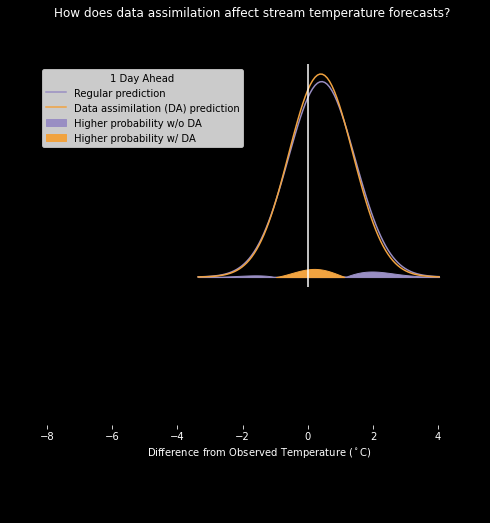

In [16]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [8,
                                                                                                    0, 0, 0, 0, 
                                                                                                    0, 0, 0,0.1,0.1]})
fig.suptitle('How does data assimilation affect stream temperature forecasts?\n',
                         color = obj_col, fontsize = 12)

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
    ax[count].set_facecolor(face_col)
    ax[count].set_xlim(min(min_ls), max(max_ls))
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)


curr_day = day_ls[0]
issue_day = curr_day + pd.Timedelta(-1, unit = 'days')
curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == issue_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == issue_day) &
                                 (forecasts_no_DA['time'] == curr_day) &
                                 (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(curr_day_DA['max_temp'])
no_DA_params = norm.fit(curr_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(curr_day_DA['max_temp'].min(), curr_day_no_DA['max_temp'].min())
xmax = max(curr_day_DA['max_temp'].max(), curr_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', label = 'Regular prediction')
ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', label = 'Data assimilation (DA) prediction')
ax[0].fill_between(x[DA_pdf <= no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
ax[0].fill_between(x[DA_pdf > no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
ax[0].axvline(0, color = obj_col)
ax[0].legend(title = '1 Day Ahead', loc = 'upper left')
ax[6].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)

plt.savefig('../gif_frames_ExtraContext/0' + str(2) + '.png', dpi = 300)

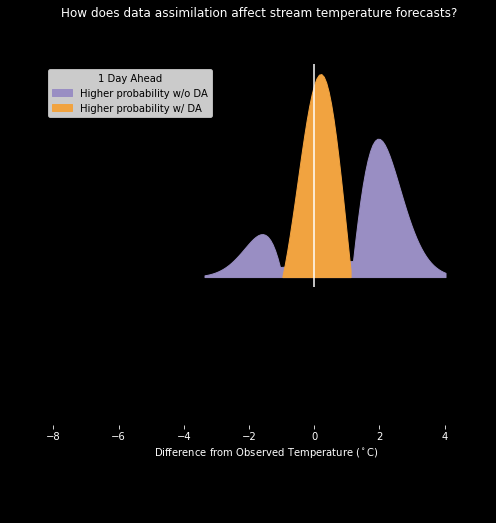

In [17]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [8,
                                                                                                    0, 0, 0, 0, 
                                                                                                    0, 0, 0,0.1,0.1]})
fig.suptitle('How does data assimilation affect stream temperature forecasts?\n',
                         color = obj_col, fontsize = 12)

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
    ax[count].set_facecolor(face_col)
    ax[count].set_xlim(min(min_ls), max(max_ls))
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)


curr_day = day_ls[0]
issue_day = curr_day + pd.Timedelta(-1, unit = 'days')
curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == issue_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == issue_day) &
                                 (forecasts_no_DA['time'] == curr_day) &
                                 (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(curr_day_DA['max_temp'])
no_DA_params = norm.fit(curr_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(curr_day_DA['max_temp'].min(), curr_day_no_DA['max_temp'].min())
xmax = max(curr_day_DA['max_temp'].max(), curr_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3', label = 'Regular prediction')
#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340', label = 'Data assimilation (DA) prediction')
ax[0].fill_between(x[DA_pdf <= no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
ax[0].fill_between(x[DA_pdf > no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
ax[0].axvline(0, color = obj_col)
ax[0].legend(title = '1 Day Ahead', loc = 'upper left')
ax[6].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)

plt.savefig('../gif_frames_ExtraContext/0' + str(3) + '.png', dpi = 300)

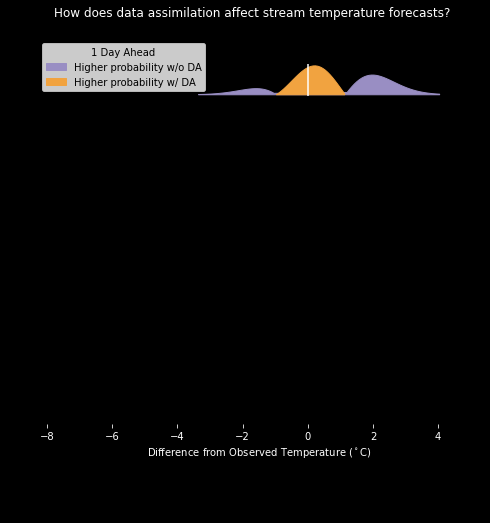

In [18]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [1,
                                                                                                    1, 1, 1, 1, 
                                                                                                    1, 1, 0,0.1,0.1]})
fig.suptitle('How does data assimilation affect stream temperature forecasts?\n',
                         color = obj_col, fontsize = 12)

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
    ax[count].set_facecolor(face_col)
    ax[count].set_xlim(min(min_ls), max(max_ls))
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)


curr_day = day_ls[0]
issue_day = curr_day + pd.Timedelta(-1, unit = 'days')
curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == issue_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == issue_day) &
                                 (forecasts_no_DA['time'] == curr_day) &
                                 (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(curr_day_DA['max_temp'])
no_DA_params = norm.fit(curr_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(curr_day_DA['max_temp'].min(), curr_day_no_DA['max_temp'].min())
xmax = max(curr_day_DA['max_temp'].max(), curr_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3')
#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340')
ax[0].fill_between(x[DA_pdf <= no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA')
ax[0].fill_between(x[DA_pdf > no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA')
ax[0].axvline(0, color = obj_col)
ax[0].legend(title = '1 Day Ahead', loc = 'lower left')
ax[6].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)

plt.savefig('../gif_frames_ExtraContext/0' + str(4) + '.png', dpi = 300)

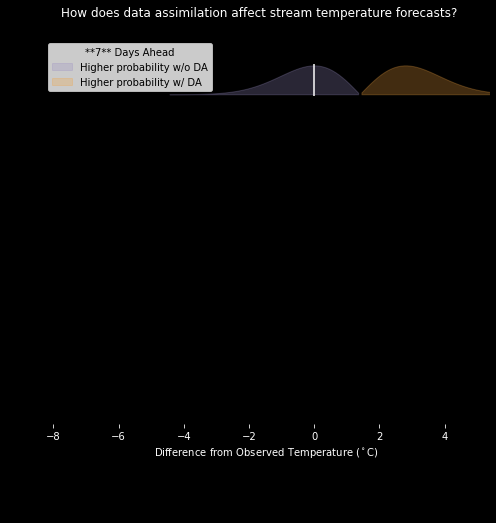

In [19]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [1,
                                                                                                    1, 1, 1, 1, 
                                                                                                    1, 1, 0,0.1,0.1]})
fig.suptitle('How does data assimilation affect stream temperature forecasts?\n',
                         color = obj_col, fontsize = 12)

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
    ax[count].set_facecolor(face_col)
    ax[count].set_xlim(min(min_ls), max(max_ls))
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)


curr_day = day_ls[0]
issue_day = curr_day + pd.Timedelta(-7, unit = 'days')
curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == issue_day) &
                           (forecasts_DA['time'] == curr_day) &
                           (forecasts_DA['seg_id_nat'] == rand_seg)]
curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == issue_day) &
                                 (forecasts_no_DA['time'] == curr_day) &
                                 (forecasts_no_DA['seg_id_nat'] == rand_seg)]

# Find distribution parameters that match our model samples
DA_params = norm.fit(curr_day_DA['max_temp'])
no_DA_params = norm.fit(curr_day_no_DA['max_temp'])

# Identify a common grid for both distribution (DA and no DA)
xmin = min(curr_day_DA['max_temp'].min(), curr_day_no_DA['max_temp'].min())
xmax = max(curr_day_DA['max_temp'].max(), curr_day_no_DA['max_temp'].max())
x = np.linspace(xmin, xmax, 100)

# Approximate the distribution along that grid
DA_pdf = norm(*DA_params).pdf(x)
no_DA_pdf = norm(*no_DA_params).pdf(x)

# Separate curves for the min and max of the two approximations
y1 = np.minimum(DA_pdf, no_DA_pdf)
y2 = np.maximum(DA_pdf, no_DA_pdf)

#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), no_DA_pdf, color = '#998ec3')
#ax[0].plot(x - curr_day_DA['obs_max_temp_c'].unique(), DA_pdf, color = '#f1a340')
ax[0].fill_between(x[DA_pdf <= no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                 color = '#998ec3', label = 'Higher probability w/o DA', alpha = 0.1364256480218281*2)
ax[0].fill_between(x[DA_pdf > no_DA_pdf] - curr_day_DA['obs_max_temp_c'].unique(), y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                 color = '#f1a340', label = 'Higher probability w/ DA', alpha = 0.1364256480218281*2)
ax[0].axvline(0, color = obj_col)
ax[0].legend(title = '**7** Days Ahead', loc = 'lower left')
ax[6].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)
plt.savefig('../gif_frames_ExtraContext/0' + str(5) + '.png', dpi = 300)

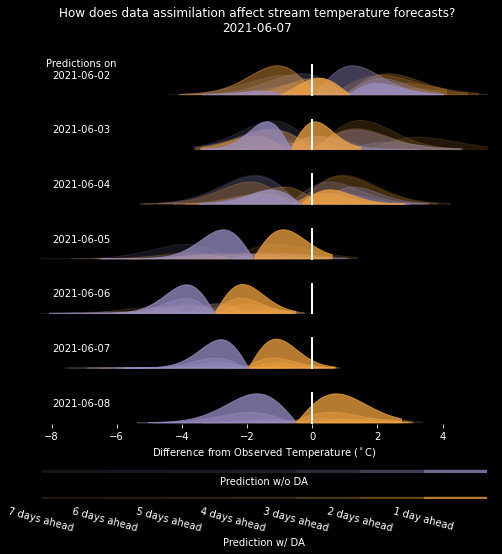

In [20]:
# Plot set up
fig, ax = plt.subplots(10, 1, figsize = (8, 8), facecolor = face_col, gridspec_kw={'height_ratios': [1,
                                                                                                    1, 1, 1, 1, 
                                                                                                    1, 1, 0,0.1,0.1]})

# Some plot formatting - for minimalism/cleanliness
for count in range(10):
    ax[count].spines['left'].set_color('none')
    ax[count].spines['bottom'].set_color('none')
    ax[count].spines['top'].set_color('none')
    ax[count].spines['right'].set_color('none')
    ax[count].tick_params(axis='x', color='none', labelcolor = 'none')
ax[6].tick_params(axis='x', color=obj_col, labelcolor = obj_col)
fig.subplots_adjust(hspace=1)

# Put the manual colorbar in for the No DA predictions
ax[7].set_facecolor(face_col)
cmap = (mpl.colors.ListedColormap(cmap_ls2))
bounds = list(range(8))
norm_c = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm_c),
    cax=ax[8],
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal'
)

# Put the manual colorbar in for the DA predictions
ax[8].set_facecolor(face_col)
cbar.ax.set_xticklabels(['', '','', '', '','',  '', '']);
cbar.set_label('Prediction w/o DA', color = obj_col, fontsize = 10, labelpad = -4)
cmap = (mpl.colors.ListedColormap(cmap_ls1))
bounds = list(range(8))
norm_c = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm_c),
    cax=ax[9],
    ticks=bounds,
    spacing='proportional',
    orientation='horizontal'
)
ax[9].set_facecolor(face_col)
cbar.ax.set_xticklabels(['7 days ahead', '6 days ahead',
                         '5 days ahead', '4 days ahead', '3 days ahead',
                         '2 days ahead',  '1 day ahead', ''],
                       rotation = -15, color = obj_col)
cbar.set_label('Prediction w/ DA', color = obj_col, fontsize = 10)

plot_count = 0
# For our 1 week of interest, start looping through takes from 1 week ago to 1 week in the future
# (because forecasts for the first day of interest were made 1 week ago)
for i in range(-7, 7):
    # Partition the data
    curr_day = rand_day + pd.Timedelta(i, unit = 'days')
    curr_day_DA = forecasts_DA[(forecasts_DA['issue_time'] == curr_day) &
                               (forecasts_DA['time'] != curr_day) &
                               (forecasts_DA['seg_id_nat'] == rand_seg)]
    curr_day_no_DA = forecasts_no_DA[(forecasts_no_DA['issue_time'] == curr_day) &
                                     (forecasts_no_DA['time'] != curr_day) &
                                     (forecasts_no_DA['seg_id_nat'] == rand_seg)]
    
    count = 0 # things that happen when we've cycled to a forecast for a day of interest
    count_arb = 0 # things that happen for every forecast issue day
    for DayOI in day_ls:
        if DayOI in curr_day_DA['time'].values:
            # Looking at a specific day of interest
            curr_day_DA_further = curr_day_DA[(curr_day_DA['time'] == DayOI)]
            curr_day_no_DA_further = curr_day_no_DA[curr_day_no_DA['time'] == DayOI]
            
            fig.suptitle('How does data assimilation affect stream temperature forecasts?\n' + str(curr_day)[:10],
                         color = obj_col, fontsize = 12)
            
            # Do those same distribution approximations and comparison
            DA_params = norm.fit(curr_day_DA_further['max_temp'])
            no_DA_params = norm.fit(curr_day_no_DA_further['max_temp'])
            xmin = min(curr_day_DA_further['max_temp'].min(), curr_day_no_DA_further['max_temp'].min())
            xmax = max(curr_day_DA_further['max_temp'].max(), curr_day_no_DA_further['max_temp'].max())
            x = np.linspace(xmin, xmax, 100)
            DA_pdf = norm(*DA_params).pdf(x)
            no_DA_pdf = norm(*no_DA_params).pdf(x)
            y1 = np.minimum(DA_pdf, no_DA_pdf)
            y2 = np.maximum(DA_pdf, no_DA_pdf)
            
            # Plot the shades areas
            # forecasts made further ahead are more transparent
            ax[count].fill_between(x[DA_pdf <= no_DA_pdf] - curr_day_DA_further['obs_max_temp_c'].unique(),
                                   0,
                                   y2[DA_pdf <= no_DA_pdf]-y1[DA_pdf <= no_DA_pdf],
                                   color = '#998ec3',
                                   alpha = 1/((DayOI - curr_day).days + 0.33)) 
            ax[count].fill_between(x[DA_pdf > no_DA_pdf] - curr_day_DA_further['obs_max_temp_c'].unique(),
                                   0,
                                   y2[DA_pdf > no_DA_pdf]-y1[DA_pdf > no_DA_pdf],
                                   color = '#f1a340',
                                   alpha = 1/((DayOI - curr_day).days + 0.33))
            
        # Observation for reference
        ax[count].axvline(0, color = obj_col)
            
        # Aesthetics/formatting
        ax[count_arb].set_yticks([])
        if DayOI == day_ls[0]:
            ax[count_arb].set_ylabel('Predictions on\n' + str(DayOI)[:10], color = obj_col, rotation = 0, labelpad = -40, fontsize = 10)
        else:
            ax[count_arb].set_ylabel('' + str(DayOI)[:10], color = obj_col, rotation = 0, labelpad = -40, fontsize = 10)
        ax[count_arb].set_facecolor(face_col)
        ax[count_arb].set_xlim(min(min_ls), max(max_ls))
        count_arb += 1
        count += 1
        if count == 6:
            ax[count].set_xlabel('Difference from Observed Temperature (${^\circ}$C)', color = obj_col, fontsize = 10)
            
    # Save each iteration for gif creation
    if (plot_count + 6) < 10:
        plt.savefig('../gif_frames_ExtraContext/0' + str(plot_count + 6) + '.png', dpi = 300)
    else:
        plt.savefig("../gif_frames_ExtraContext/" + str(plot_count + 6) + '.png', dpi = 300)
        
    plot_count += 1

In [21]:
# Switch to the directory with the gif frames
import os
os.chdir("../gif_frames_ExtraContext/")

In [22]:
# Use imagemagick to make the gif
!magick convert -delay 100 -loop 0 *.png forecast_comparison.gif